This is a Julian fork of the 12 steps to Navier-Stokes (Python) [https://github.com/barbagroup/CFDPython] by Lorena A. Barba, Gilbert F. Forsyth . All content of that work is under Creative Commons Attribution CC-BY 4.0, and all python code is under BSD-3 clause. This work also derives from similar forks by Cysor [https://github.com/Cysor/CFDJulia] and by Wallace-dyfq [https://github.com/Wallace-dyfq/CFD-Julia-12-steps--o-Navier-Stokes-Equations]

In the previous step, we solved the 2D Burger' equation: an important equation in the study of fluid mechanics because it contains the full convective nonlinearity of the flow equations. With that exercise, we also build the experience to incrementatlly code a Navier-Stokes solver.

In the next two steps, we will solve Laplace and then Poisson equation. We will then put it all together!

Step 9: 2D Laplace Equation
----
***

Here is Laplace's equation in 2D:

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = 0$$

We know how to discretize a 2nd order derivative. But think about this for a minute — Laplace's equation has the features typical of diffusion phenomena. For this reason, it has to be discretized with *central differences*, so that the discretization is consistent with the physics we want to simulate. 

The discretized equation is:

$$\frac{p_{i+1, j}^n - 2p_{i,j}^n + p_{i-1,j}^n}{\Delta x^2} + \frac{p_{i,j+1}^n - 2p_{i,j}^n + p_{i, j-1}^n}{\Delta y^2} = 0$$

Notice that the Laplace Equation does not have a time dependence — there is no $p^{n+1}$.  Instead of tracking a wave through time (like in the previous steps), the Laplace equation calculates the equilibrium state of a system under the supplied boundary conditions.  

If you have taken coursework in Heat Transfer, you will recognize the Laplace Equation as the steady-state heat equation.  

Instead of calculating where the system will be at some time $t$, we will iteratively solve for $p_{i,j}^n$ until it meets a condition that we specify.  The system will reach equilibrium only as the number of iterations tends to $\infty$, but we can approximate the equilibrium state by iterating until the change between one iteration and the next is *very* small.  

Let's rearrange the discretized equation, solving for $p_{i,j}^n$:

$$p_{i,j}^n = \frac{\Delta y^2(p_{i+1,j}^n+p_{i-1,j}^n)+\Delta x^2(p_{i,j+1}^n + p_{i,j-1}^n)}{2(\Delta x^2 + \Delta y^2)}$$

Using second-order central-difference schemes in both directions is the most widely applied method for the Laplace operator. It is also known as the **five-point difference operator**, alluding to its stencil.

We are going to solve Laplace's equation numerically by assuming an initial state of $p=0$ everywhere. Then we add boundary conditions as follows:

$p=0$ at $x=0$

$p=y$ at $x=2$

$\frac{\partial p}{\partial y}=0$ at $y=0, \ 1$

Under these conditions, there is an analytical solution for Laplace's equation:

$$p(x,y)=\frac{x}{4}-4\sum_{n=1,odd}^{\infty}\frac{1}{(n\pi)^2\sinh2n\pi}\sinh n\pi x\cos n\pi y$$

In [1]:
using LinearAlgebra

function laplace2d(p, x, y, Δx, Δy, l1norm_target)
    
    l1norm = 1;
    pn = zeros(size(p));
    count_max = 1000000;
    count = 1;
    
    row = size(y,1)
    col = size(x,1)
    
    while (l1norm > l1norm_target && count < count_max)
        
        pn .= p
        
        for j in 1:row
            for i in 1:col
                if j == 1
                    p[j,i] = p[2,i]   #dp/dy = 0 @ y = 0
                elseif j == row
                    p[j,i] = p[row-1,i]   #dp/dy = 0 @ y = 1
                elseif i == col
                    p[j,i] = y[j]    #p = y @ x = 2
                elseif i == 1
                    p[j,i] = 0.0    #p = 0 @ x = 0
                else
                    p[j,i] = ( Δy^2*(pn[j, i+1] + pn[j, i-1]) + Δx^2*(pn[j+1, i] + pn[j-1, i]) ) / 2.0 / (Δx^2 + Δy^2)
                end
            end
        end
       
        l1norm = norm((p-pn)./(pn.+1.0e-30),1)
        count +=1;
 
    end
    
    @show l1norm, count
    p

end




laplace2d (generic function with 1 method)

In [2]:
using Plots


nx = 31
ny = 31

    
Δx = 2.0 / (nx - 1)
Δy = 2.0 / (ny - 1)
    

x = range(0.0, stop=2.0, length=nx)
y = range(0.0, stop=1.0, length=ny)

p₀ = zeros(ny, nx)

p₀[:,1] .= 0;     #p = 0 @ x = 0
p₀[:,end] .= y;    #p = y @ x = 2
p₀[1,:] .= p₀[2,:];    #dp/dy = 0 @ y = 0
p₀[end,:] .= p₀[end-1,:];  ##dp/dy = 0 @ y = 1

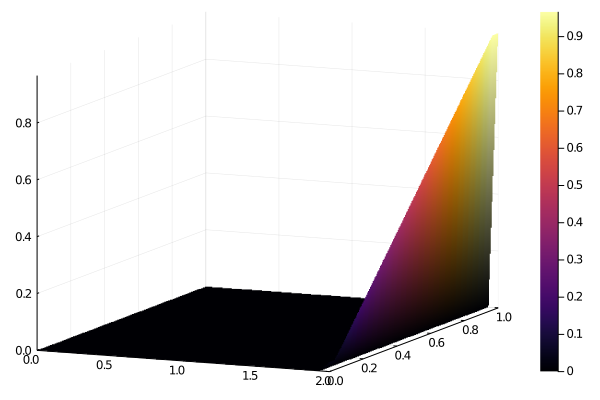

In [3]:
plot(x, y, p₀, st=:surface)

It worked!  This is the initial state of our problem, where the value of `p` is zero everywhere except for along $x=2$ where $p=y$.  Now let's try to run our `laplace2d` function with a specified L1 target of .01

[Hint: if you are having trouble remembering the order in which variables are sent to a function, you can just type `laplace2d(` and the iPython Notebook will put up a little popup box to remind you]

(l1norm, count) = (9.987930712444068e-5, 3798)


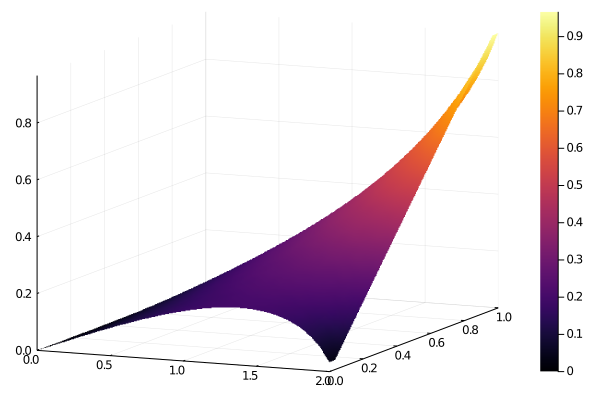

In [4]:
p = laplace2d(p₀, x, y, Δx, Δy, 1e-4);

plot(x, y, p, st=:surface,camera=(120,120))

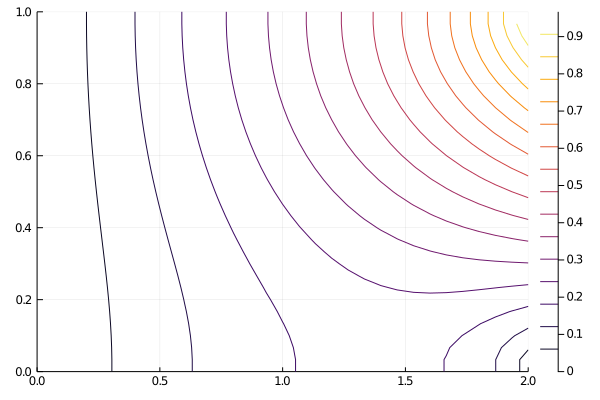

In [5]:
plot(x, y, p, st=:contour)